# Flight Delay Prediction

Kaggle Flight delays
https://www.kaggle.com/c/flight-delays-spring-2018/overview

Steps:

- data
- preprocess
- feature extraction / creation column etc
- eda
- modelling
    - preprocess
    - pipeline creation
    - model selection
    - parameter tuning - gridsearch
    - validation evaluation
    - final model
    - test evaluation

In [ ]:
SEED = 55

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

import utils.plot_utils as plt_utils

In [3]:
train_df = pd.read_csv('data/flight_delays_train.csv')
test_df = pd.read_csv('data/flight_delays_test.csv')

In [4]:
print(train_df.shape)
train_df.head()

(100000, 9)


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [5]:
train_df['delayed'] = train_df['dep_delayed_15min'].apply(lambda x:'No' if x=='N' else 'Yes' )
train_df.drop(columns=['dep_delayed_15min'], inplace=True)

In [6]:
print(test_df.shape)
test_df.head()

(100000, 8)


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DepTime,100000.0,1341.52388,476.378445,1.0,931.0,1330.0,1733.0,2534.0
Distance,100000.0,729.39716,574.616860,30.0,317.0,575.0,957.0,4962.0


In [8]:
# preprocess data:

def preprocess_date_data(df, col):
    # delete c's 
    df[col] = df[col].apply(lambda x: x.replace('c-',''))
    df[col] = df[col].astype('category')
    return df

for c in ['Month', 'DayofMonth', 'DayOfWeek']:
    train_df = preprocess_date_data(df=train_df, col=c)
    test_df = preprocess_date_data(df=test_df, col=c)

In [9]:
train_df['DepTime'].nunique()

1300

In [10]:
train_df['DepTime'].value_counts(normalize=True)

700     0.00359
600     0.00307
655     0.00249
800     0.00239
1500    0.00237
         ...   
2500    0.00001
219     0.00001
506     0.00001
2412    0.00001
302     0.00001
Name: DepTime, Length: 1300, dtype: float64

We can treat the departure time based on only hours.

In [11]:
train_df['DepHour'] = train_df['DepTime'].apply(lambda x: x//100)
# 0 and 24 is same hour interval
train_df['DepHour'] = train_df['DepHour'].apply(lambda x: 0 if x == 24 else x)
train_df['DepHour'] = train_df['DepHour'].astype('category')

test_df['DepHour'] = test_df['DepTime'].apply(lambda x: x//100)
# 0 and 24 is same hour interval
test_df['DepHour'] = test_df['DepHour'].apply(lambda x: 0 if x == 24 else x)
test_df['DepHour'] = test_df['DepHour'].astype('category')

In [12]:
print(train_df['DepHour'].unique().tolist())

[19, 15, 14, 10, 18, 7, 6, 20, 17, 12, 21, 16, 9, 13, 11, 23, 8, 5, 22, 0, 4, 2, 1, 3, 25]


In [13]:
train_df[train_df['DepTime']>=2400]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,delayed,DepHour
3558,7,9,6,2400,B6,OAK,IAD,2408,Yes,0
6423,9,7,3,2400,B6,SEA,JFK,2421,No,0
8189,6,14,2,2435,EV,CVG,AVL,275,Yes,0
11652,12,9,6,2400,US,LAS,OAK,407,No,0
16603,3,27,7,2400,HP,LAS,ATL,1747,Yes,0
20766,5,31,2,2534,EV,ATL,HSV,151,Yes,25
24350,12,27,2,2400,DL,LAX,CVG,1900,No,0
27391,3,23,4,2505,EV,ATL,AGS,143,Yes,25
44332,7,15,5,2440,EV,ATL,SHV,552,Yes,0
45796,8,18,4,2447,EV,ATL,JAN,341,Yes,0


In [14]:
# Wrong data??? you can exclude..
train_df[train_df['DepTime']>=2500]
train_df = train_df[train_df['DepTime']<2500]

In [15]:
print(test_df['DepHour'].unique().tolist())
assert(test_df[test_df['DepTime']>2500].shape[0] == 0)

[6, 7, 16, 15, 8, 11, 17, 18, 9, 20, 5, 13, 19, 21, 14, 10, 12, 23, 2, 22, 0, 1, 4, 3]


In [16]:
train_df.sample(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,delayed,DepHour
66977,7,24,7,1314,UA,DEN,IAH,861,No,13
47440,10,4,2,850,AS,SFO,SEA,679,No,8
75600,7,11,2,824,US,BOS,PHL,280,No,8
2059,11,8,2,915,B6,JFK,MCO,944,No,9
62929,1,3,2,615,AA,TPA,STL,869,No,6
18601,11,9,3,1758,US,PVD,PHL,238,No,17
50683,1,29,6,859,XE,EWR,DAB,884,No,8
28745,8,18,5,1607,US,CLT,CHS,168,No,16
28377,2,26,6,1810,US,PIT,TPA,873,Yes,18
22444,7,8,6,857,US,PHX,MCO,1848,No,8


In [17]:
# check value types and see if it makes sense
train_df.dtypes

Month            category
DayofMonth       category
DayOfWeek        category
DepTime             int64
UniqueCarrier      object
Origin             object
Dest               object
Distance            int64
delayed            object
DepHour          category
dtype: object

### Sanity Checks

In [18]:
# Check missing values  -- No missing values in the data
print(f'Train data: \n{train_df.isna().sum()}\n')
print(f'Test data: \n{test_df.isna().sum()}')

Train data: 
Month            0
DayofMonth       0
DayOfWeek        0
DepTime          0
UniqueCarrier    0
Origin           0
Dest             0
Distance         0
delayed          0
DepHour          0
dtype: int64

Test data: 
Month            0
DayofMonth       0
DayOfWeek        0
DepTime          0
UniqueCarrier    0
Origin           0
Dest             0
Distance         0
DepHour          0
dtype: int64


In [19]:
# Duplicate Data  -- No Duplicate rows
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


# Further Exploration - Exploratory Analysis

## Unique Carrier, Origin and Destination

In [20]:
# Check unique values for Categorical Variables
categorical_vars = ['Month', 'DayofMonth', 'DayOfWeek', 'DepHour', 'UniqueCarrier', 'Origin', 'Dest']
for cat_var in categorical_vars:
    print(f'{cat_var}: \n # uniques: {train_df[cat_var].nunique()} \n unique values: {train_df[cat_var].unique()} \n-----')

Month: 
 # uniques: 12 
 unique values: [8, 4, 9, 11, 10, ..., 6, 5, 3, 12, 2]
Length: 12
Categories (12, object): [8, 4, 9, 11, ..., 5, 3, 12, 2] 
-----
DayofMonth: 
 # uniques: 31 
 unique values: [21, 20, 2, 25, 7, ..., 8, 12, 13, 11, 23]
Length: 31
Categories (31, object): [21, 20, 2, 25, ..., 12, 13, 11, 23] 
-----
DayOfWeek: 
 # uniques: 7 
 unique values: [7, 3, 5, 6, 4, 2, 1]
Categories (7, object): [7, 3, 5, 6, 4, 2, 1] 
-----
DepHour: 
 # uniques: 24 
 unique values: [19, 15, 14, 10, 18, ..., 0, 4, 2, 1, 3]
Length: 24
Categories (24, int64): [19, 15, 14, 10, ..., 4, 2, 1, 3] 
-----
UniqueCarrier: 
 # uniques: 22 
 unique values: ['AA' 'US' 'XE' 'OO' 'WN' 'NW' 'DL' 'OH' 'AS' 'UA' 'MQ' 'CO' 'EV' 'DH'
 'YV' 'F9' 'AQ' 'TZ' 'HP' 'B6' 'FL' 'HA'] 
-----
Origin: 
 # uniques: 289 
 unique values: ['ATL' 'PIT' 'RDU' 'DEN' 'MDW' 'MEM' 'PBI' 'MSP' 'ONT' 'BDL' 'PHX' 'LAS'
 'DFW' 'DSM' 'CMH' 'ORF' 'SLC' 'CLT' 'GSO' 'IAD' 'SMF' 'FLL' 'DAL' 'ORD'
 'ITO' 'SAN' 'ROA' 'LGA' 'SFO' 'GSP' 'SEA' 'D

## Carrier vs flight distribution by delayed/not delayed flight

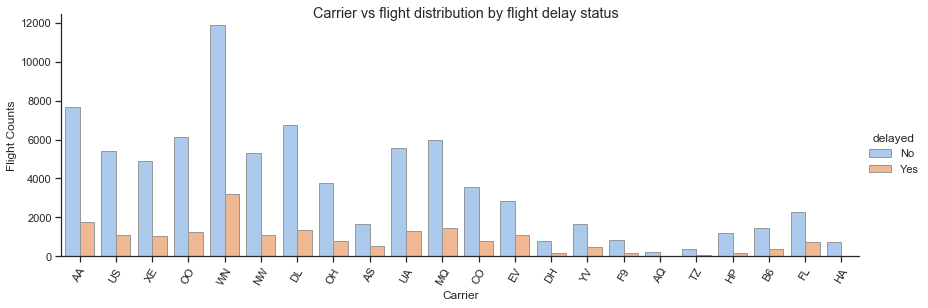

In [21]:
plt_utils.catplot(df=train_df, 
        x="UniqueCarrier", hue="delayed", kind="count",
        title='Carrier vs flight distribution by flight delay status',
        xlab="Carrier", ylab="Flight Counts" )

In [22]:
# rate of flight delays for each carrier
carrier_delay_rate =  pd.DataFrame(train_df.groupby(by=['UniqueCarrier','delayed']).size())
carrier_delay_rate.reset_index(inplace=True)
carrier_delay_rate.rename(columns={0:'flight_counts'}, inplace=True)

In [23]:
cdr_pivoted = carrier_delay_rate.pivot_table(values='flight_counts', index='UniqueCarrier', columns='delayed')
cdr_pivoted['delay_percentage'] = cdr_pivoted.apply(lambda x: round(x['Yes']*100/(x['Yes']+x['No']),2), axis=1)
cdr_pivoted.sort_values(by='delay_percentage', ascending=False, inplace=True)
cdr_pivoted.head(5)

delayed,No,Yes,delay_percentage
UniqueCarrier,,,
EV,2848,1076,27.42
AS,1681,541,24.35
FL,2303,736,24.22
YV,1650,478,22.46
B6,1445,393,21.38


In [24]:
cdr_pivoted.tail(5)

delayed,No,Yes,delay_percentage
UniqueCarrier,,,
F9,850,156,15.51
TZ,382,64,14.35
HP,1182,196,14.22
AQ,216,18,7.69
HA,729,33,4.33


In [25]:
cdr_pivoted.describe()

delayed,No,Yes,delay_percentage
count,22.000000,22.000000,22.000000
mean,3679.818182,865.363636,17.806818
std,2958.802213,740.248706,5.114921
min,216.000000,18.000000,4.330000
25%,1247.750000,245.250000,16.297500
50%,3197.000000,798.000000,17.490000
75%,5514.750000,1229.000000,20.867500
max,11863.000000,3219.000000,27.420000


Text(0.5, 0, 'Carrier')

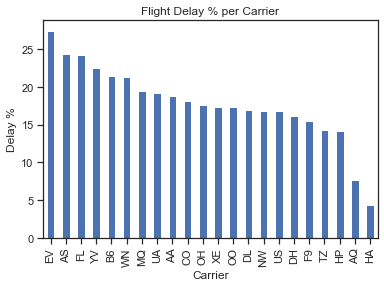

In [26]:
ax = cdr_pivoted.delay_percentage.plot(kind='bar', title='Flight Delay % per Carrier')
ax.set_ylabel('Delay %')
ax.set_xlabel('Carrier')

In [27]:
cdr_pivoted.head(2)

delayed,No,Yes,delay_percentage
UniqueCarrier,,,
EV,2848,1076,27.42
AS,1681,541,24.35


In [28]:
cdr_pivoted['flight_count'] = cdr_pivoted['Yes'] + cdr_pivoted ['No']
cdr_pivoted['flight_percentage'] = cdr_pivoted['flight_count']*100 / cdr_pivoted['flight_count'].sum()
cdr_pivoted.sort_values(by='flight_count', ascending=False, inplace=True)

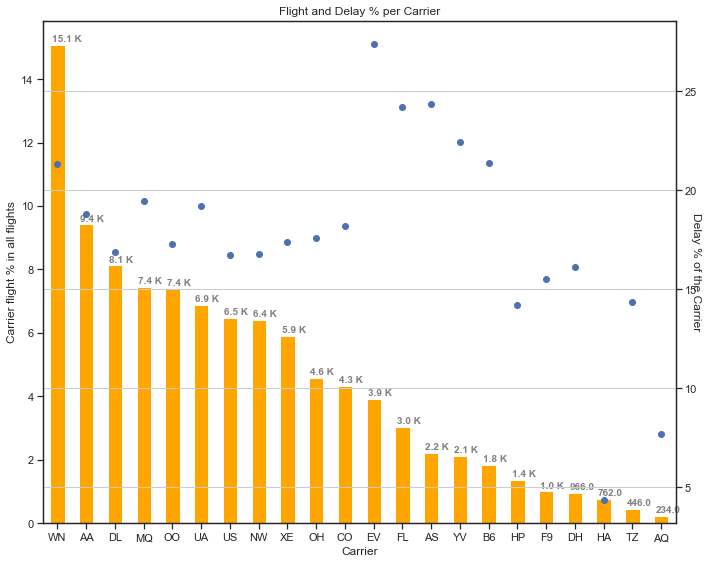

In [29]:
fig, ax1 = plt.subplots(figsize=(10, 8))
cdr_pivoted['flight_percentage'].plot(kind='bar', color='orange', title='Flight and Delay % per Carrier')
ax1.set_ylabel('Carrier flight % in all flights')

cdr_pivoted['delay_percentage'].plot(marker='o', secondary_y=True,
            linestyle = 'None')
for i, (count, percent) in enumerate(zip(cdr_pivoted.flight_count.tolist(),cdr_pivoted.flight_percentage.tolist())):
    ax1.text(i-0.2, percent+0.1, str(plt_utils.human_format(count)), color='gray', fontweight='bold', fontsize=10, rotation=0)

ax1.set_xlabel('Carrier')
plt.ylabel('Delay % of the Carrier', rotation=-90)
ax.legend(numpoints=1)
plt.tight_layout()
plt.grid()
plt.xlim(-0.5,21.5)
plt.show()

In [30]:
def col_count_df(df, col, target):
    delay_df = pd.DataFrame(df.groupby([col,target]).size()).reset_index()
    delay_df.rename(columns={0:'flight_count'}, inplace=True)
    counts_df = pd.DataFrame(df[col].value_counts())
    counts_df.reset_index(inplace=True)
    counts_df.rename(columns={'index':col.lower(),col:'flight_count'}, inplace=True)
    return delay_df, counts_df

## Origin vs flight distributionn by delayed/not delayed flight (Top X origins)

In [31]:
most_freq=50
col = 'Origin'
target = 'delayed'
org_delay_df, org_counts_df = col_count_df(df=train_df, col=col, target=target)
top_origins = org_counts_df.origin.head(most_freq).tolist()

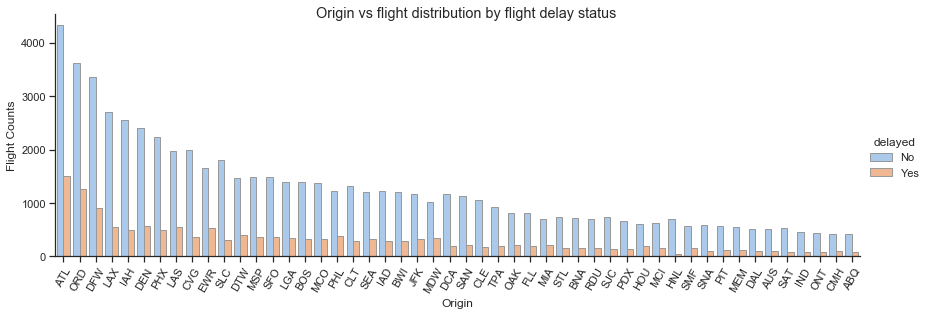

In [32]:
plt_utils.catplot(df=org_delay_df[org_delay_df[col].isin(top_origins)], 
        x=col, y='flight_count', hue=target, kind='bar',
        order=top_origins, title=f'{col} vs flight distribution by flight delay status',
        xlab=col, ylab="Flight Counts" , rot=60)

In [33]:
org_delay_df.head(2)

,Origin,delayed,flight_count
0,ABE,No,59
1,ABE,Yes,8


In [34]:
org_delay_df['rate'] = org_delay_df.apply(lambda x: round(x['flight_count']*100/ org_counts_df[org_counts_df['origin']==x['Origin']].flight_count.values[0],2), axis=1)
org_delay_df.head(3)

,Origin,delayed,flight_count,rate
0,ABE,No,59,88.06
1,ABE,Yes,8,11.94
2,ABI,No,20,80.00


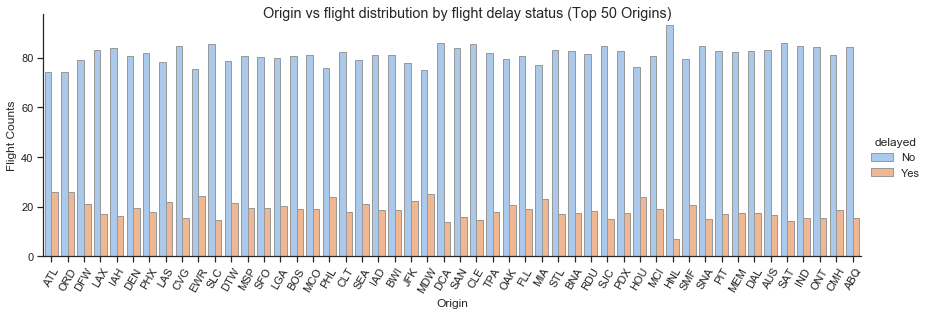

In [35]:
plt_utils.catplot(df=org_delay_df[org_delay_df[col].isin(top_origins)], 
        x=col, y='rate', hue=target, kind='bar',
        order=top_origins, title=f'{col} vs flight distribution by flight delay status (Top 50 Origins)',
        xlab=col, ylab="Flight Counts" , rot=60)

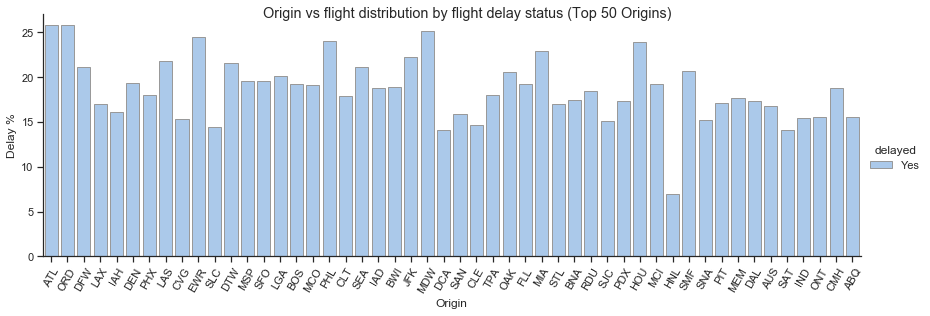

In [36]:
plt_utils.catplot(df=org_delay_df[(org_delay_df[col].isin(top_origins)) & (org_delay_df.delayed=='Yes')], 
        x=col, y='rate', hue=target, kind='bar',
        order=top_origins, title=f'{col} vs flight distribution by flight delay status (Top 50 Origins)',
        xlab=col, ylab="Delay %" , rot=60)

In [37]:
org_delay_df.sort_values(by='flight_count', ascending=False).T

,34,396,155,298,257,153,414,139,294,492,...,102,100,82,233,78,73,241,253,263,175
Origin,ATL,ORD,DFW,LAX,IAH,DEN,PHX,CVG,LAS,SLC,...,CDV,CDC,BTM,GTR,BRO,BPT,HLN,HTS,ILG,ERI
delayed,No,No,No,No,No,No,No,No,No,No,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes
flight_count,4328,3616,3368,2707,2556,2398,2238,1986,1967,1799,...,1,1,1,1,1,1,1,1,1,1
rate,74.25,74.25,78.88,83.06,83.86,80.66,82.01,84.69,78.27,85.54,...,7.69,10,5.56,6.67,3.57,16.67,3.23,10,100,7.14


In [38]:
org_delay_df.rate.describe()

count    555.000000
mean      52.072072
std       34.140730
min        2.220000
25%       17.360000
50%       66.670000
75%       83.915000
max      100.000000
Name: rate, dtype: float64

#### Cumulative Sum- Percentage Plots in top origins.

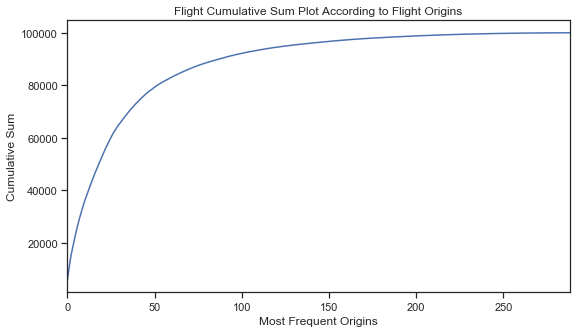

25% Flights are covered with most frequent 6 locations
50% Flights are covered with most frequent 18 locations
90% Flights are covered with most frequent 87 locations
99% Flights are covered with most frequent 207 locations


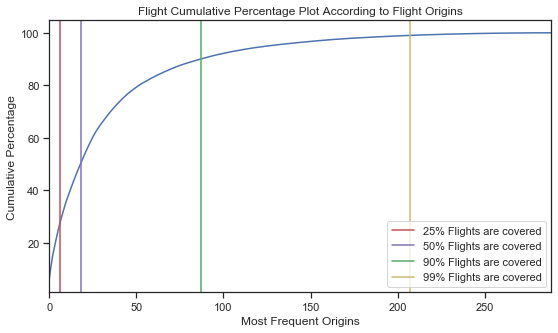

In [39]:
plt_utils.cum_sum_plot(df =org_counts_df, col='flight_count',  gtype='cum_sum', 
             title='Flight Cumulative Sum Plot According to Flight Origins',
             xlabel='Most Frequent Origins',ylabel='Cumulative Sum')

plt_utils.cum_sum_plot(df =org_counts_df, col='flight_count',  gtype='cum_perc', 
             title='Flight Cumulative Percentage Plot According to Flight Origins',
             xlabel='Most Frequent Origins',ylabel='Cumulative Percentage',vert_lines=True, coltype='Flights' )

In [40]:
org_counts_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
origin,ATL,ORD,DFW,LAX,IAH,DEN,PHX,LAS,CVG,EWR,...,SNA,PIT,MEM,DAL,AUS,SAT,IND,ONT,CMH,ABQ
flight_count,5829,4870,4270,3259,3048,2973,2729,2513,2345,2196,...,690,688,668,629,620,609,550,514,507,502
cum_sum,5829,10699,14969,18228,21276,24249,26978,29491,31836,34032,...,73506,74194,74862,75491,76111,76720,77270,77784,78291,78793
cum_perc,5.82935,10.6996,14.9699,18.2291,21.2773,24.2505,26.9796,29.4928,31.8379,34.034,...,73.5104,74.1985,74.8665,75.4955,76.1156,76.7246,77.2746,77.7887,78.2957,78.7977


In [41]:
# 25, 50 75% of origins
for prc in [25,50,75,90]:
    print(org_counts_df[org_counts_df.cum_perc<=prc].shape[0])

6
18
43
87


In [42]:
list(org_counts_df.origin[:6])

['ATL', 'ORD', 'DFW', 'LAX', 'IAH', 'DEN']

In [43]:
# flight count rank vs delay rate
org_delay_df[(org_delay_df.delayed=='Yes') & org_delay_df['Origin'].isin(list(org_counts_df.origin[:6]))].sort_values(by='flight_count', ascending=False
                                                                                                                             )

,Origin,delayed,flight_count,rate
35,ATL,Yes,1501,25.75
397,ORD,Yes,1254,25.75
156,DFW,Yes,902,21.12
154,DEN,Yes,575,19.34
299,LAX,Yes,552,16.94
258,IAH,Yes,492,16.14


In [44]:
delayed = org_delay_df[org_delay_df.delayed=='Yes'].copy()
delayed.sort_values(by='flight_count', ascending=False, inplace=True)
delayed.reset_index(drop=True,inplace=True)
delayed.head(2)

,Origin,delayed,flight_count,rate
0,ATL,Yes,1501,25.75
1,ORD,Yes,1254,25.75


In [45]:
delayed.flight_count.sum()

19038

In [46]:
delayed.describe()

,flight_count,rate
count,269.000000,269.000000
mean,70.773234,18.979182
std,166.228681,12.806452
min,1.000000,2.220000
25%,4.000000,13.330000
50%,13.000000,17.130000
75%,50.000000,20.970000
max,1501.000000,100.000000


25% Delays are covered with most frequent 4 locations
50% Delays are covered with most frequent 16 locations
90% Delays are covered with most frequent 78 locations
99% Delays are covered with most frequent 187 locations


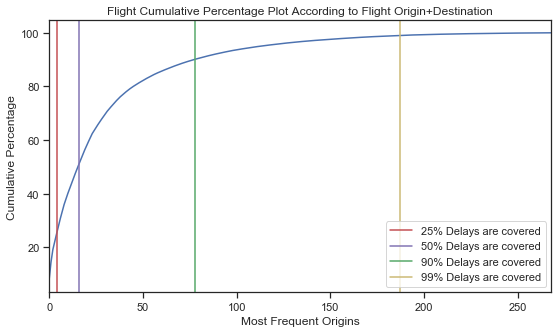

In [47]:
plt_utils.cum_sum_plot(df =delayed, col='flight_count',  gtype='cum_perc', 
             title='Flight Cumulative Percentage Plot According to Flight Origin+Destination',
             xlabel='Most Frequent Origins',ylabel='Cumulative Percentage',vert_lines=True, coltype='Delays' )

In [48]:
delayed[delayed['Origin'].isin(list(org_counts_df.origin[:6]))].rate.mean()

20.84

In [49]:
delayed[delayed['Origin'].isin(list(org_counts_df.origin[:6]))]

,Origin,delayed,flight_count,rate,cum_sum,cum_perc
0,ATL,Yes,1501,25.75,1501,7.884232
1,ORD,Yes,1254,25.75,2755,14.471058
2,DFW,Yes,902,21.12,3657,19.208951
3,DEN,Yes,575,19.34,4232,22.229226
4,LAX,Yes,552,16.94,4784,25.128690
7,IAH,Yes,492,16.14,6360,33.406870


In [50]:
delayed[delayed['Origin'].isin(list(org_counts_df.origin[:6]))].flight_count.sum()*100/delayed.flight_count.sum()

27.712995062506565

# Destination vs flight distribution by delayed/not delayed flight

In [51]:
most_freq=50
col = 'Dest'
target = 'delayed'
dest_delay_df, dest_counts_df = col_count_df(df=train_df, col=col, target=target)
top_destinations = dest_counts_df[col.lower()].head(most_freq).tolist()

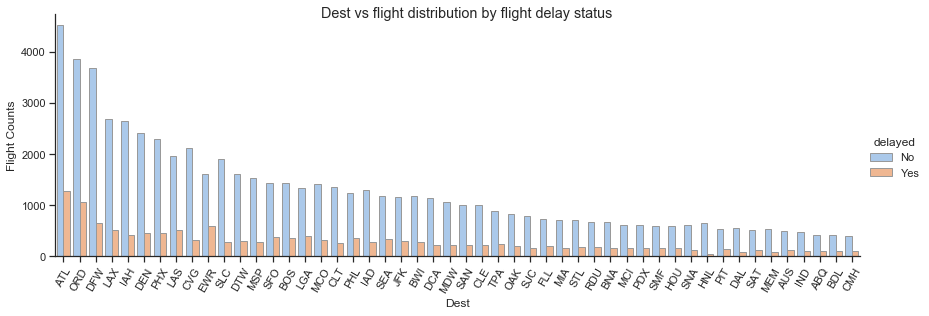

In [52]:
plt_utils.catplot(df=dest_delay_df[dest_delay_df[col].isin(top_destinations)], 
        x=col, y='flight_count', hue=target, kind='bar',
        order=top_destinations, title=f'{col} vs flight distribution by flight delay status',
        xlab=col, ylab="Flight Counts" , rot=60)

#### Cumulative Sum- Percentage Plots in top origins.

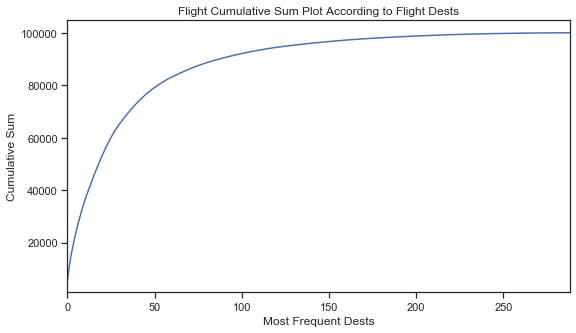

25% Flights are covered with most frequent 6 locations
50% Flights are covered with most frequent 18 locations
90% Flights are covered with most frequent 87 locations
99% Flights are covered with most frequent 208 locations


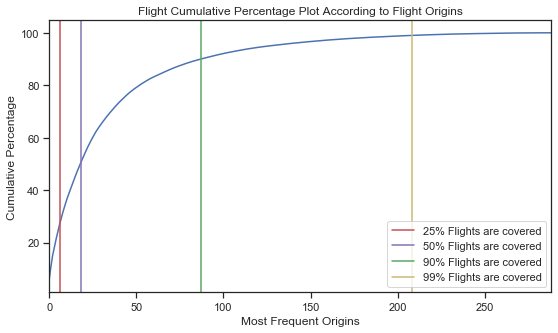

In [53]:
plt_utils.cum_sum_plot(df =dest_counts_df, col='flight_count',  gtype='cum_sum', 
             title=f'Flight Cumulative Sum Plot According to Flight {col}s',
             xlabel=f'Most Frequent {col}s',ylabel='Cumulative Sum')

plt_utils.cum_sum_plot(df =dest_counts_df, col='flight_count',  gtype='cum_perc', 
             title='Flight Cumulative Percentage Plot According to Flight Origins',
             xlabel='Most Frequent Origins',ylabel='Cumulative Percentage',vert_lines=True, coltype='Flights' )

In [54]:
dest_counts_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
dest,ATL,ORD,DFW,LAX,IAH,DEN,PHX,LAS,CVG,EWR,...,HNL,PIT,DAL,SAT,MEM,AUS,IND,ABQ,BDL,CMH
flight_count,5795,4933,4337,3205,3056,2866,2749,2475,2434,2190,...,702,676,655,631,629,612,579,535,519,497
cum_sum,5795,10728,15065,18270,21326,24192,26941,29416,31850,34040,...,73370,74046,74701,75332,75961,76573,77152,77687,78206,78703
cum_perc,5.79535,10.7286,15.0659,18.2711,21.3273,24.1935,26.9426,29.4178,31.8519,34.042,...,73.3744,74.0504,74.7055,75.3365,75.9656,76.5776,77.1566,77.6917,78.2107,78.7077


In [55]:
# 25, 50 75% of origins
for prc in [25,50,75,90]:
    print(dest_counts_df[dest_counts_df.cum_perc<=prc].shape[0])

6
18
43
87


# Origin + Destination vs flight distribution by delayed/not delayed flight

In [56]:
most_freq=50
train_df['Org+Dest'] = train_df['Origin']+'-'+train_df['Dest']
test_df['Org+Dest'] = test_df['Origin']+'-'+test_df['Dest']
col = 'Org+Dest'
target = 'delayed'
dest_delay_df, dest_counts_df = col_count_df(df=train_df, col=col, target=target)
top_destinations = dest_counts_df[col.lower()].head(most_freq).tolist()

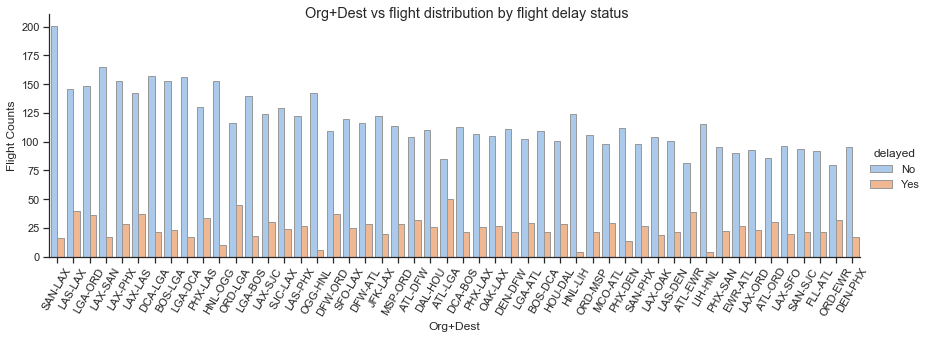

In [57]:
plt_utils.catplot(df=dest_delay_df[dest_delay_df[col].isin(top_destinations)], 
        x=col, y='flight_count', hue=target, kind='bar',
        order=top_destinations, title=f'{col} vs flight distribution by flight delay status',
        xlab=col, ylab="Flight Counts" , rot=60)

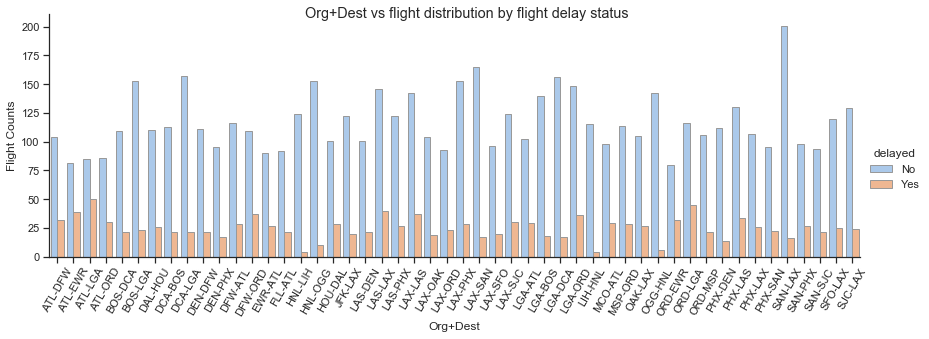

In [58]:
plt_utils.catplot(df=dest_delay_df[(dest_delay_df[col].isin(top_destinations))],# & (dest_delay_df['delayed']=='Yes')], 
        x=col, y='flight_count', hue=target, kind='bar', title=f'{col} vs flight distribution by flight delay status',
        xlab=col, ylab="Flight Counts" , rot=60)

In [59]:
dest_counts_df.head(2)

,org+dest,flight_count
0,SAN-LAX,217
1,LAS-LAX,186


25% Flights are covered with most frequent 269 locations
50% Flights are covered with most frequent 796 locations
90% Flights are covered with most frequent 2629 locations
99% Flights are covered with most frequent 3865 locations


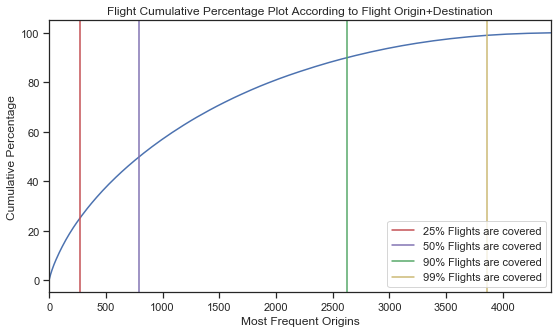

In [60]:
plt_utils.cum_sum_plot(df =dest_counts_df, col='flight_count',  gtype='cum_perc', 
             title='Flight Cumulative Percentage Plot According to Flight Origin+Destination',
             xlabel='Most Frequent Origins',ylabel='Cumulative Percentage',vert_lines=True, coltype='Flights' )

In [61]:
dest_counts_df['org+dest'].nunique()

4429

In [62]:
delayed = dest_delay_df[dest_delay_df.delayed=='Yes'].copy()
delayed.sort_values(by='flight_count', ascending=False, inplace=True)
delayed.reset_index(inplace=True)
delayed.head(2)

,index,Org+Dest,delayed,flight_count
0,352,ATL-LGA,Yes,50
1,5742,ORD-LGA,Yes,45


In [63]:
delayed.flight_count.sum()

19038

In [64]:
delayed.describe()

,index,flight_count
count,3553.000000,3553.000000
mean,3931.163242,5.358289
std,2283.320435,5.461240
min,1.000000,1.000000
25%,1955.000000,2.000000
50%,3929.000000,3.000000
75%,5900.000000,7.000000
max,7918.000000,50.000000


25% Delays are covered with most frequent 222 locations
50% Delays are covered with most frequent 645 locations
90% Delays are covered with most frequent 2233 locations
99% Delays are covered with most frequent 3362 locations


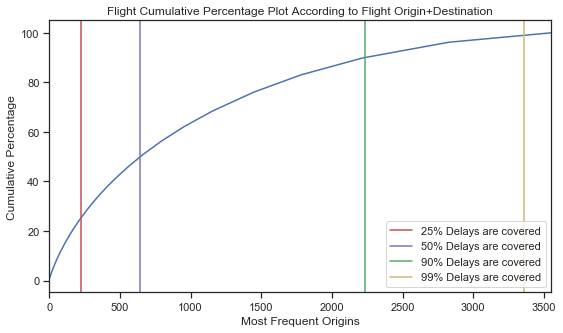

In [65]:
plt_utils.cum_sum_plot(df =delayed, col='flight_count',  gtype='cum_perc', 
             title='Flight Cumulative Percentage Plot According to Flight Origin+Destination',
             xlabel='Most Frequent Origins',ylabel='Cumulative Percentage',vert_lines=True, coltype='Delays' )

In [66]:
dest_counts_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
org+dest,SAN-LAX,LAS-LAX,LGA-ORD,LAX-SAN,LAX-PHX,LAX-LAS,DCA-LGA,BOS-LGA,LGA-DCA,PHX-LAS,...,LIH-HNL,PHX-SAN,EWR-ATL,LAX-ORD,ATL-ORD,LAX-SFO,SAN-SJC,FLL-ATL,ORD-EWR,DEN-PHX
flight_count,217,186,184,182,181,179,178,176,173,164,...,119,117,117,116,116,116,115,113,112,112
cum_sum,217,403,587,769,950,1129,1307,1483,1656,1820,...,6070,6187,6304,6420,6536,6652,6767,6880,6992,7104
cum_perc,0.217013,0.403024,0.587035,0.769046,0.950057,1.12907,1.30708,1.48309,1.6561,1.82011,...,6.07036,6.18737,6.30438,6.42039,6.53639,6.6524,6.76741,6.88041,6.99242,7.10443


In [67]:
dest_counts_df['org+dest'].nunique()

4429

In [68]:
# 25, 50 75% of origins
for prc in [25,50,75,90]:
    print(dest_counts_df[dest_counts_df.cum_perc<=prc].shape[0])

269
796
1688
2629


# Time Data Exploration

In [69]:
months = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}
days = {'01':'Mon','02':'Tue','03':'Wed','04':'Thu','05':'Fri','06':'Sat','07':'Sun'}

In [70]:
def order_list_nums(num):
    x = ",".join(str(i) for i in list(range(1,num+1)))
    order_list = x.split(",")
    return order_list

In [71]:
train_df.head(2)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,delayed,DepHour,Org+Dest
0,8,21,7,1934,AA,ATL,DFW,732,No,19,ATL-DFW
1,4,20,3,1548,US,PIT,MCO,834,No,15,PIT-MCO


In [72]:
def show_count_plots():
    plt_utils.catplot(df=train_df, 
        x=col, hue="delayed", kind="count", order=order_list_nums(12),
        title=f'{col} vs flight distribution by flight delay status',
        xlab=col, ylab="Flight Counts" )
    
def percent_plot(df, col, y='perc', target='delayed', label_dic =None, only_delayed=True,order_nums=None, title='' ):
    day_of_month_df = pd.DataFrame(df.groupby(by=[col,target]).size())
    day_of_month_df.reset_index(inplace=True)
    day_of_month_df.rename(columns={0:'flight_counts'}, inplace=True)
    if y=='perc':
        day_of_month_df[y] = day_of_month_df.apply(lambda x: x['flight_counts']*100/day_of_month_df[day_of_month_df[col]==x[col]].flight_counts.sum(),axis=1)
    if label_dic:
        xlabels =label_dic.values()
    else: xlabels=None
    if only_delayed:
        df_plotted = day_of_month_df[day_of_month_df[target]=='Yes']
    else: df_plotted = day_of_month_df
    plt_utils.catplot(df=df_plotted, order=order_nums,
            x=col, y=y, hue=target, kind='bar',
            title=f'{col} '+title,
            xlab=col, ylab="Flight %" , xticklabs=xlabels, rot=0, color='red')
    return day_of_month_df   

#### Month distribution of flights by delayed/not delayed flight

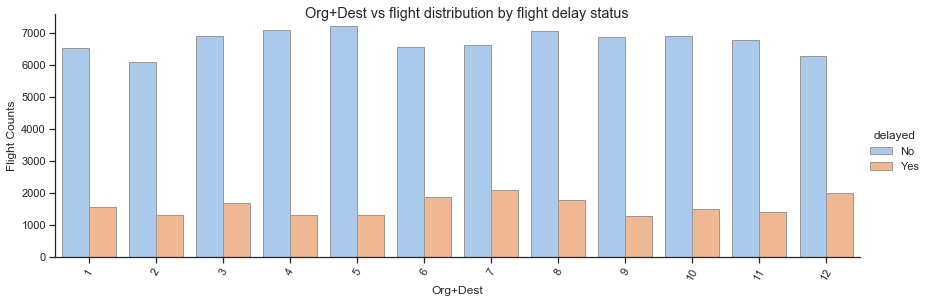

In [73]:
plt_utils.catplot(df=train_df, order=order_list_nums(12),
        x='Month', hue="delayed", kind="count",
        title=f'{col} vs flight distribution by flight delay status',
        xlab=col, ylab="Flight Counts" )

#### Day of Month distribution of flights by delayed/not delayed flight

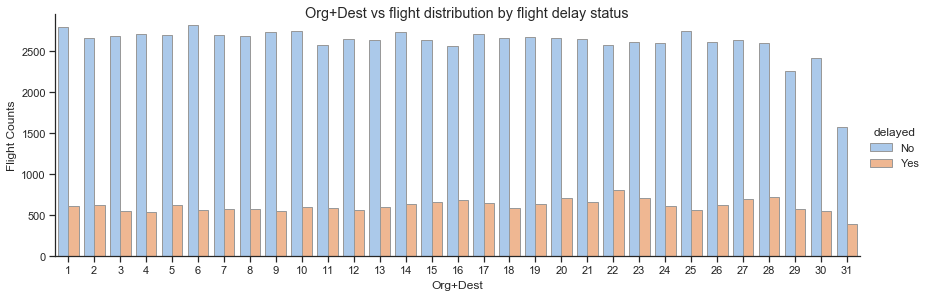

In [74]:
plt_utils.catplot(df=train_df, order=order_list_nums(31),
        x='DayofMonth', hue="delayed", kind="count",
        title=f'{col} vs flight distribution by flight delay status',
        xlab=col, ylab="Flight Counts" , rot=0)

#### Day of Week distribution of flights by delayed/not delayed flight

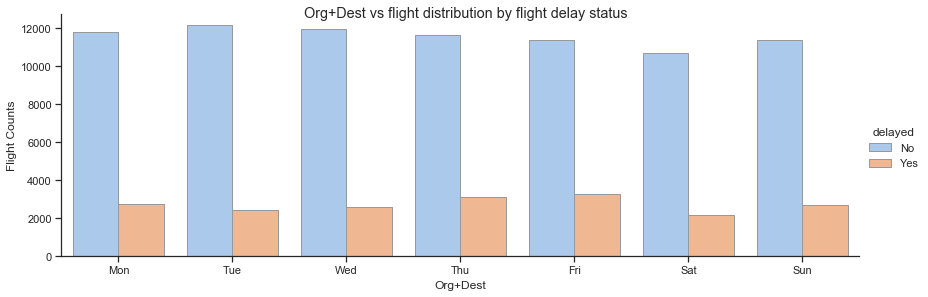

In [75]:
plt_utils.catplot(df=train_df, order=order_list_nums(7),
        x='DayOfWeek', hue="delayed", kind="count",
        title=f'{col} vs flight distribution by flight delay status',
        xlab=col, ylab="Flight Counts" , xticklabs=days.values(), rot=0)

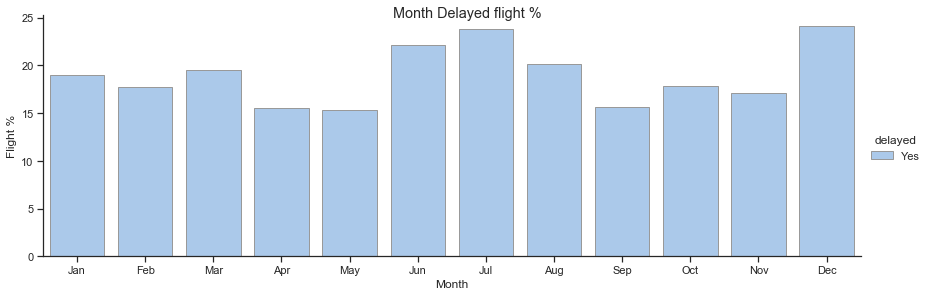

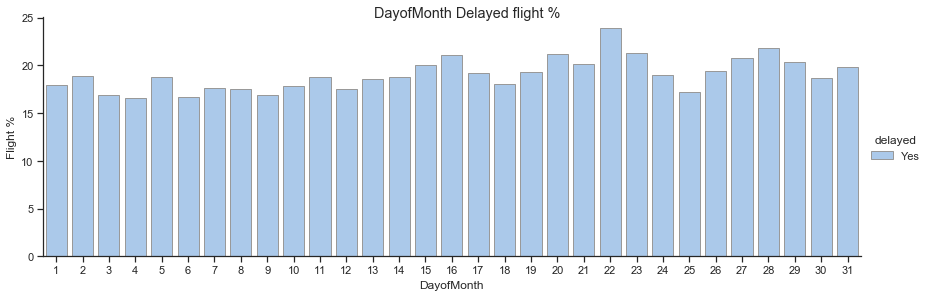

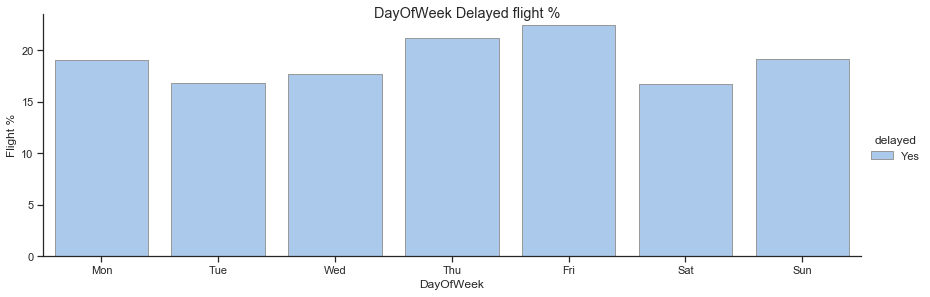

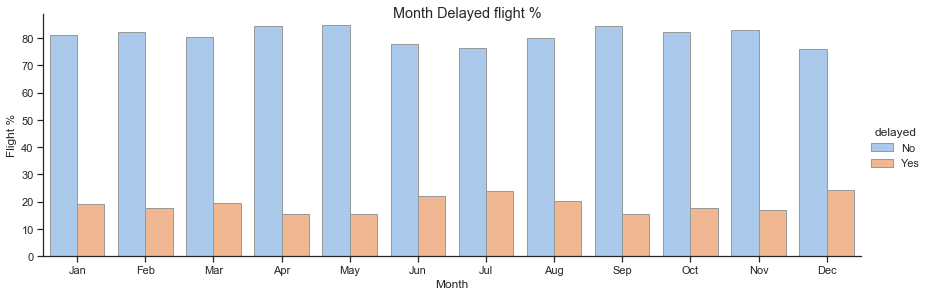

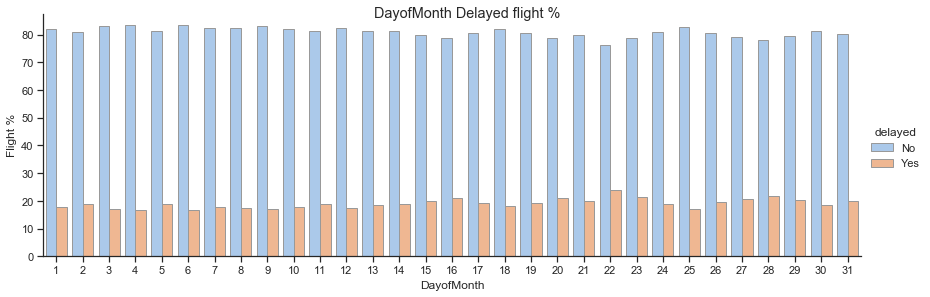

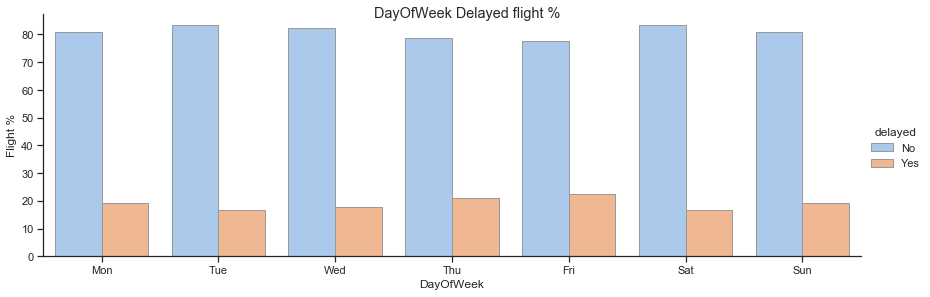

In [76]:
for c, labs, ol in zip(['Month','DayofMonth', 'DayOfWeek'], [months, None, days], [order_list_nums(12),order_list_nums(31),order_list_nums(7)]):
    _ =percent_plot(df=train_df, col=c, y='perc', target="delayed", label_dic=labs, order_nums=ol, title='Delayed flight %')
for c, labs, ol in zip(['Month','DayofMonth', 'DayOfWeek'], [months, None, days], [order_list_nums(12),order_list_nums(31),order_list_nums(7)]):
    _ =percent_plot(df=train_df, col=c, y='perc', target="delayed", only_delayed=False, label_dic=labs, order_nums=ol, title='Delayed flight %')


In [77]:
train_df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'delayed', 'DepHour', 'Org+Dest'],
      dtype='object')

In [78]:
train_df['DayOfWeek'].value_counts(normalize=True)

4    0.147359
5    0.146579
2    0.146029
1    0.145689
3    0.145089
7    0.140958
6    0.128298
Name: DayOfWeek, dtype: float64

In [79]:
res = pd.DataFrame(train_df.groupby(by=['DepTime','delayed']).size())
res.reset_index(inplace=True)
res.rename(columns={0:'flight_counts'}, inplace=True)

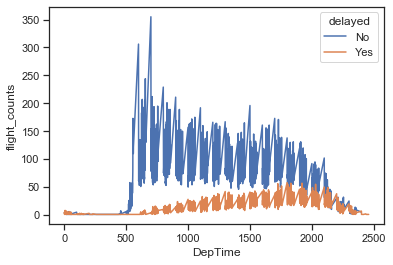

In [80]:
sns.lineplot(data=res, x="DepTime", y="flight_counts", hue='delayed')

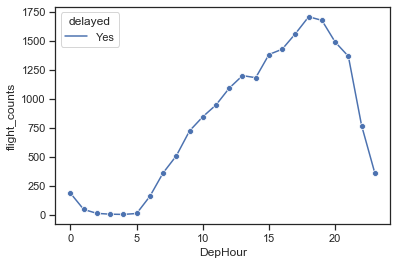

In [81]:
res = pd.DataFrame(train_df.groupby(by=['DepHour','delayed']).size())
res.reset_index(inplace=True)
res.rename(columns={0:'flight_counts'}, inplace=True)
sns.lineplot(data=res[res.delayed=='Yes'], x="DepHour", y="flight_counts",marker='o', hue='delayed')


In [82]:
res[res.delayed=='Yes'].describe().T

,count,mean,std,min,25%,50%,75%,max
flight_counts,24.0,793.25,607.060075,3.0,179.25,808.0,1371.75,1709.0


In [83]:
delay_dep_hour = res[res.delayed=='Yes'].copy()
delay_dep_hour['perc'] = delay_dep_hour['flight_counts'] *100/delay_dep_hour['flight_counts'].sum()
delay_dep_hour

,DepHour,delayed,flight_counts,perc
1,0,Yes,186,0.976993
3,1,Yes,46,0.241622
5,2,Yes,12,0.063032
7,3,Yes,5,0.026263
9,4,Yes,3,0.015758
11,5,Yes,11,0.057779
13,6,Yes,159,0.835172
15,7,Yes,361,1.896208
17,8,Yes,509,2.673600
19,9,Yes,724,3.802920


In [84]:
delay_dep_hour[delay_dep_hour['DepHour'].isin([15,16,17,18,19,20,21])]['perc'].sum()

55.78842315369262

In [85]:
delay_dep_hour[delay_dep_hour['DepHour'].isin([17,18,19])]['perc'].sum()

26.000630318310744

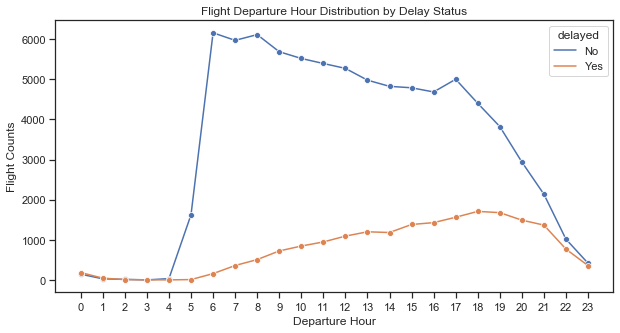

In [86]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(data=res, x="DepHour", y="flight_counts", hue='delayed', marker='o')
ax.set_title('Flight Departure Hour Distribution by Delay Status')
ax.set_xlabel('Departure Hour')
ax.set_ylabel('Flight Counts')
ax.set_xticks(list(range(24)))

In [87]:
train_df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'delayed', 'DepHour', 'Org+Dest'],
      dtype='object')

Text(0.5, 0.98, 'Flight Distance Distribution by Delay Status')

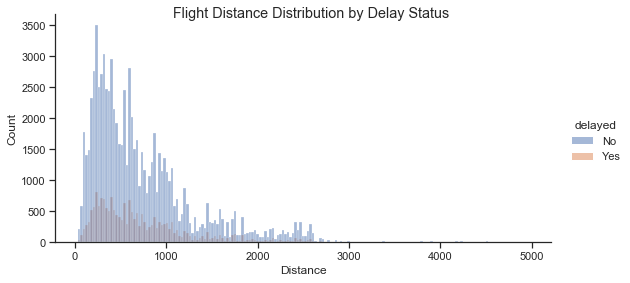

In [88]:
# Distance plots
#sns.distplot x="Distance", hue="delayed", data=train_df, binwidth=100)
g = sns.displot(x="Distance", hue="delayed", data=train_df, height=4, aspect=2)
g.fig.suptitle('Flight Distance Distribution by Delay Status')

Text(0.5, 1.0, 'Flight Distance Distribution by Delay Status')

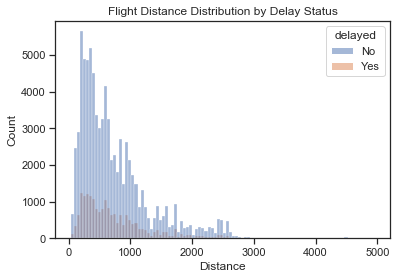

In [89]:
g = sns.histplot(x="Distance", hue="delayed", data=train_df, bins=100)
g.set_title('Flight Distance Distribution by Delay Status')

In [90]:
train_df.Distance.describe()

count    99994.000000
mean       729.422445
std        574.622971
min         30.000000
25%        317.000000
50%        575.000000
75%        957.000000
max       4962.000000
Name: Distance, dtype: float64

In [91]:
(5000-30)/100

49.7

In [92]:
dist_delay_df = train_df[['Distance','delayed']].copy()
dist_delay_df

,Distance,delayed
0,732,No
1,834,No
2,416,No
3,872,No
4,423,Yes
...,...,...
99995,199,No
99996,884,No
99997,1076,No
99998,140,No


In [93]:
bins_range = list(range(0,5000,200))
dist_delay_df['Distance_bins'] = pd.cut(dist_delay_df['Distance'], bins=bins_range, retbins=False)

In [94]:
dist_delay_df.Distance_bins.nunique()

23

In [95]:
dist_delay_df.Distance_bins.value_counts()

(200, 400]      24361
(400, 600]      18380
(600, 800]      13121
(800, 1000]     11202
(0, 200]        10218
(1000, 1200]     7228
(1400, 1600]     3374
(1200, 1400]     3170
(1600, 1800]     2378
(2400, 2600]     1820
(1800, 2000]     1753
(2200, 2400]     1204
(2000, 2200]     1137
(2600, 2800]      373
(2800, 3000]       93
(4400, 4600]       34
(3800, 4000]       33
(3200, 3400]       28
(4200, 4400]       27
(3600, 3800]       26
(4000, 4200]       16
(3000, 3200]        4
(3400, 3600]        3
(4600, 4800]        0
Name: Distance_bins, dtype: int64

In [96]:
dist_delay_rate =  pd.DataFrame(dist_delay_df.groupby(by=['Distance_bins','delayed']).size())
dist_delay_rate.reset_index(inplace=True)
dist_delay_rate.rename(columns={0:'flight_counts'}, inplace=True)
dist_delay_rate['percent_withinbin'] = dist_delay_rate.apply(lambda x: x['flight_counts']*100/dist_delay_rate[dist_delay_rate['Distance_bins']==x['Distance_bins']].flight_counts.sum(), axis=1)
dist_delay_rate['percent_within_delayed_flights'] = dist_delay_rate.apply(lambda x: round(x['flight_counts']*100/dist_delay_rate[dist_delay_rate['delayed']=='Yes'].flight_counts.sum(),2) if x['delayed']=='Yes' else None, axis=1)

<Figure size 1800x720 with 0 Axes>

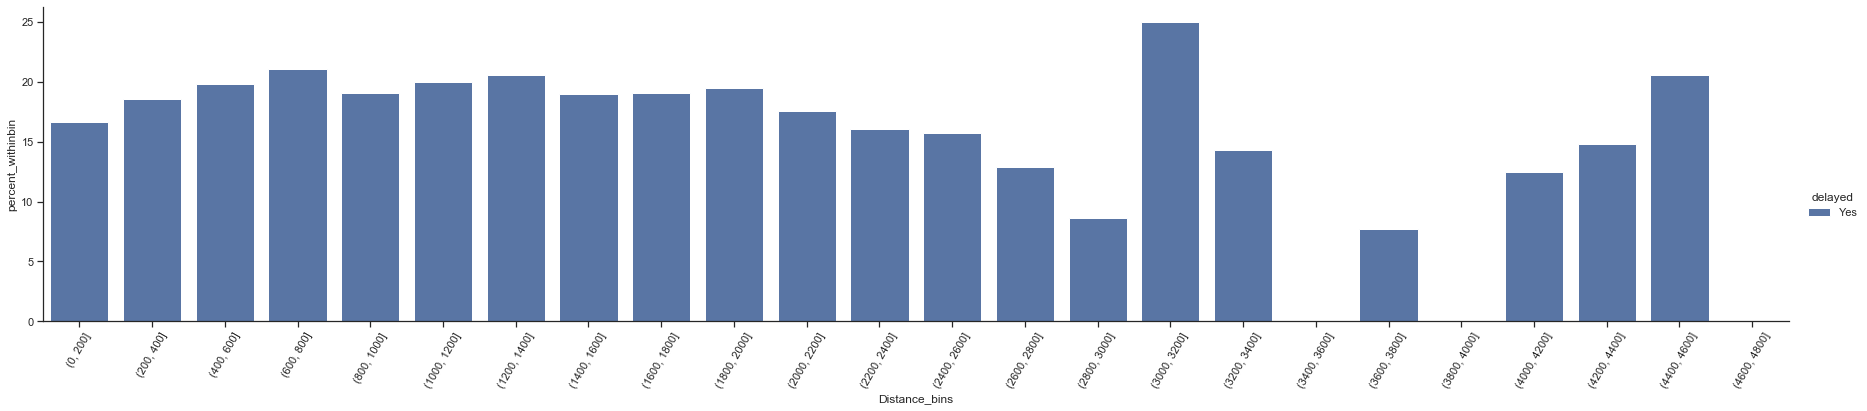

In [97]:
plt.figure(figsize=(25,10))
ax = sns.catplot(x="Distance_bins", y="percent_withinbin", hue="delayed",
                 data=dist_delay_rate[dist_delay_rate.delayed=='Yes'], kind='bar',  height=5, aspect=5)
ax.set_xticklabels(rotation=60)

Text(0.5, 0.98, 'Delayed Flight % Distribution per Distance Bins')

<Figure size 1800x720 with 0 Axes>

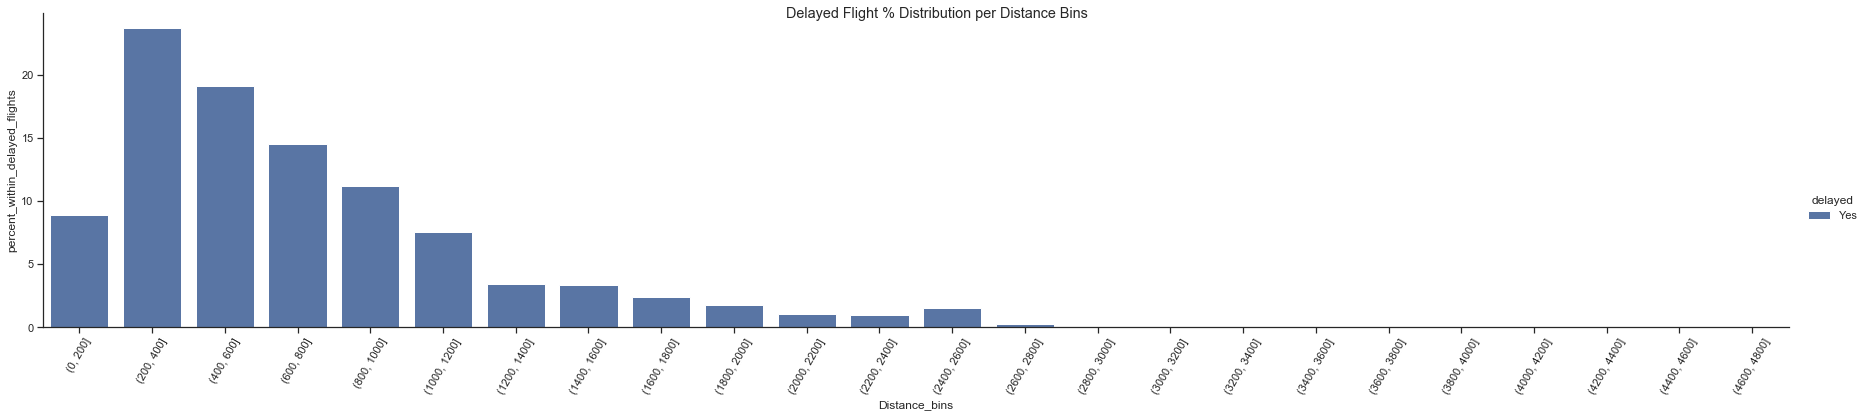

In [98]:
plt.figure(figsize=(25,10))
ax = sns.catplot(x="Distance_bins", y="percent_within_delayed_flights", hue="delayed",
                 data=dist_delay_rate[dist_delay_rate.delayed=='Yes'], kind='bar',  height=5, aspect=5)
ax.set_xticklabels(rotation=60)
ax.fig.suptitle('Delayed Flight % Distribution per Distance Bins')

In [99]:
dist_delay_rate[dist_delay_rate.delayed=='Yes']

,Distance_bins,delayed,flight_counts,percent_withinbin,percent_within_delayed_flights
1,"(0, 200]",Yes,1697,16.607947,8.91
3,"(200, 400]",Yes,4519,18.550142,23.74
5,"(400, 600]",Yes,3638,19.793254,19.11
7,"(600, 800]",Yes,2766,21.080710,14.53
9,"(800, 1000]",Yes,2134,19.050170,11.21
11,"(1000, 1200]",Yes,1442,19.950194,7.58
13,"(1200, 1400]",Yes,652,20.567823,3.43
15,"(1400, 1600]",Yes,639,18.938945,3.36
17,"(1600, 1800]",Yes,453,19.049622,2.38
19,"(1800, 2000]",Yes,341,19.452367,1.79


In [100]:
8.91+23.74+19.11+14.53

66.28999999999999

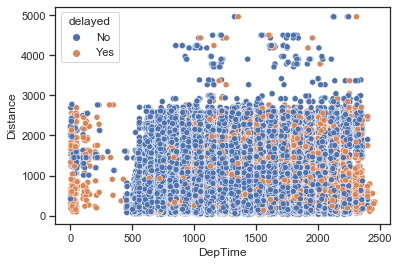

In [101]:
sns.scatterplot(data=train_df, x="DepTime", y="Distance", hue="delayed")

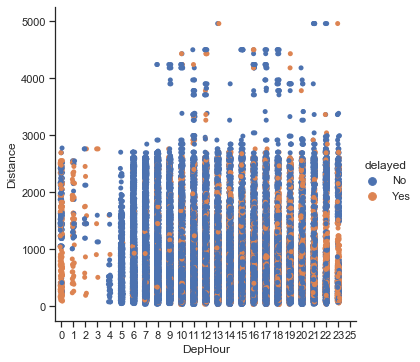

In [102]:
sns.catplot(data=train_df, x="DepHour", y="Distance", hue="delayed")

In [103]:
# Visualisation of the dependent variable vs all the other variables

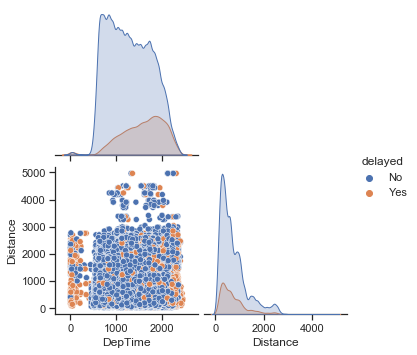

In [104]:
g = sns.pairplot(train_df, hue="delayed", corner=True)

# Model Creation

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import cross_val_score

In [106]:
train_df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'delayed', 'DepHour', 'Org+Dest'],
      dtype='object')

In [107]:
train_df.dtypes

Month            category
DayofMonth       category
DayOfWeek        category
DepTime             int64
UniqueCarrier      object
Origin             object
Dest               object
Distance            int64
delayed            object
DepHour          category
Org+Dest           object
dtype: object

In [108]:
train_data = train_df.copy()
test_data = test_df.copy()

# turn target variables into 0-1
train_data['delayed'] = train_data['delayed'].apply(lambda x: 0 if x == 'No' else 1)
train_data['delayed'] = train_data['delayed'].astype('category')

# is data imbalanced?
print(train_data.delayed.value_counts())
print(train_data.delayed.value_counts(normalize=True))

0    80956
1    19038
Name: delayed, dtype: int64
0    0.809609
1    0.190391
Name: delayed, dtype: float64


In [109]:
# excluded related features 
def exclude_columns(df, columns_to_exclude):
    df.drop(columns_to_exclude, axis=1, inplace=True)
    return df

excl_feats = ['DepHour','Org+Dest']
train_data.drop(excl_feats, axis=1, inplace=True)
#test_data.drop(excl_feats, axis=1, inplace=True)

In [110]:
train_data.dtypes

Month            category
DayofMonth       category
DayOfWeek        category
DepTime             int64
UniqueCarrier      object
Origin             object
Dest               object
Distance            int64
delayed          category
dtype: object

In [111]:
numerical_feats =  train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_feats =  train_data.select_dtypes(include=['category','object']).drop(['delayed'], axis=1).columns

print(f'Numerical Features: {numerical_feats}')
print(f'Categorical Features: {categorical_feats}')

Numerical Features: Index(['DepTime', 'Distance'], dtype='object')
Categorical Features: Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object')


In [112]:
# Treat numerical and categorical variables separately in the preprocessing step
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num_tf', numerical_transformer, numerical_feats),
                                                ('cat_tf', categorical_transformer, categorical_feats)])

In [113]:
'''
def reduce_categories_with_others(df, col, top=50, top_list =None):
    if top_list is None:
        top_values = list(df[col].value_counts().index[:top])
    else:
        top_values = top_list
    df[col+'_processed'] = df[col].apply(lambda x: x if x in top_values else 'other')
    return df, top_values

# reduce the categories values that are not in the most frequent values of that column by replacing  other 
for col in ['Origin', 'Dest']:
    train_data, top_cols = reduce_categories_with_others(df=train_data, col=col, top=20)
    test_data, _ = reduce_categories_with_others(df=test_data, col=col, top_list=top_cols)
'''

"\ndef reduce_categories_with_others(df, col, top=50, top_list =None):\n    if top_list is None:\n        top_values = list(df[col].value_counts().index[:top])\n    else:\n        top_values = top_list\n    df[col+'_processed'] = df[col].apply(lambda x: x if x in top_values else 'other')\n    return df, top_values\n\n# reduce the categories values that are not in the most frequent values of that column by replacing  other \nfor col in ['Origin', 'Dest']:\n    train_data, top_cols = reduce_categories_with_others(df=train_data, col=col, top=20)\n    test_data, _ = reduce_categories_with_others(df=test_data, col=col, top_list=top_cols)\n"

In [114]:
train_data.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'delayed'],
      dtype='object')

In [115]:
## maybe do oversampling here TODO
# import utils.data_manipulation as data_manip
# df_train_over = data_manip.oversample_data(df=train_data, target_col='delayed')
# df_train_under  = data_manip.undersample_data(df=train_data, target_col='delayed')

X_train = train_data[list(numerical_feats) + list(categorical_feats)] #df_train_over, train_data
y_train = train_data.delayed.tolist() #df_train_over, train_data

X_test = test_data[list(numerical_feats) + list(categorical_feats)] 

In [116]:
classifiers = [
    ('LR', LogisticRegression(max_iter=1000)),
    ('XGB', xgb.XGBClassifier(objective="binary:logistic", random_state=SEED)),
    #('RF', RandomForestClassifier(random_state=0)),
    ]

score_type = 'roc_auc'

for (clf_name,clf) in classifiers:
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('clf', clf)])
    cv_scores = cross_val_score(model_pipeline, X_train, y_train, 
                                cv=5,
                                scoring=score_type)

    print(f"{clf_name} Cross-validation ROC-AUC mean: %f" % cv_scores.mean())

LR Cross-validation ROC-AUC mean: 0.706364
XGB Cross-validation ROC-AUC mean: 0.743236


In [117]:
classifiers

[('LR',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=1000,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False)),
 ('XGB',
  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', random_state=55, reg_alpha=None,
                reg_lambda=None, scale_pos_weight=None, subsample=None,
                tree_method=None, validate_

Continue with XGBoost model and try to improve its AUC result.

# hyper param tuning

In [118]:
# split train data into train and validation
X_train_small, X_valid, y_train_small, y_valid= train_test_split(X_train, y_train, test_size=0.30, random_state=42)
print(X_train_small.shape)
print(X_valid.shape)

(69995, 8)
(29999, 8)


In [119]:
# cross valid
params = {'clf__learning_rate':[0.05, 0.075, 0.1],
          'clf__n_estimators':[300, 500, 750, 1000]
         }

modelpp= Pipeline(steps=[('preprocessor', preprocessor),
                                    ('clf', xgb.XGBClassifier(objective="binary:logistic", random_state=SEED))])

search = GridSearchCV(modelpp, params, scoring=score_type)
                  
search.fit(X_train_small, y_train_small)  
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.742):
{'clf__learning_rate': 0.05, 'clf__n_estimators': 1000}


In [120]:
print(search.best_estimator_)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_tf',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['DepTime', 'Distance'], dtype='object')),
                                                 ('cat_tf',
                           

Confusion Matrix 
               precision    recall  f1-score   support

           0       0.83      0.99      0.90     24297
           1       0.70      0.13      0.23      5702

    accuracy                           0.82     29999
   macro avg       0.77      0.56      0.56     29999
weighted avg       0.81      0.82      0.77     29999

[[23973   324]
 [ 4938   764]]

Accuracy is:0.825
ROC-AUC is:0.744


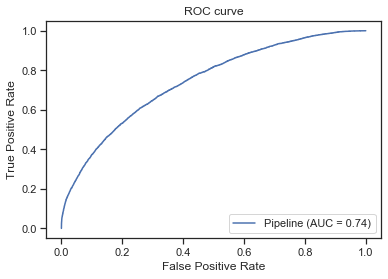

In [121]:
# Best param results in evaluation

search.best_estimator_.fit(X_train_small, y_train_small)
preds = search.best_estimator_.predict(X_valid)

print('Confusion Matrix \n', metrics.classification_report(y_valid, preds))
print(metrics.confusion_matrix(y_valid, preds))
    
print(f'\nAccuracy is:{metrics.accuracy_score(y_valid, preds):.3f}')
logit_valid_pred = search.best_estimator_.predict_proba(X_valid)[:, 1]
print(f'ROC-AUC is:{ roc_auc_score(y_valid, logit_valid_pred):.3f}')

metrics.plot_roc_curve(search.best_estimator_, X_valid, y_valid)
plt.title('ROC curve')
plt.show() 

# Ensemble model to further improve

In [122]:
def evaluate(model,x, y):
    preds = model.predict(x)
    print('Confusion Matrix \n', metrics.classification_report(y, preds))
    print(metrics.confusion_matrix(y, preds))

    pred_probab = model.predict_proba(x)[:, 1]
    print(f'ROC-AUC is:{ roc_auc_score(y, pred_probab):.3f}')

    metrics.plot_roc_curve(model, x, y)
    plt.title('ROC curve')
    plt.show() 
    return preds, pred_probab

In [123]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

Confusion Matrix 
               precision    recall  f1-score   support

           0       0.84      0.96      0.90     24297
           1       0.56      0.24      0.33      5702

    accuracy                           0.82     29999
   macro avg       0.70      0.60      0.61     29999
weighted avg       0.79      0.82      0.79     29999

[[23253  1044]
 [ 4360  1342]]
ROC-AUC is:0.750


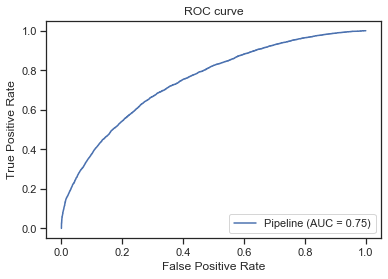

In [124]:
m1 = LogisticRegression(random_state=1,class_weight={0:2,1:8})
m2 = xgb.XGBClassifier(objective="binary:logistic", random_state=SEED,n_estimators=500,
                          learning_rate=0.3) 
m3 = xgb.XGBClassifier(objective="binary:logistic", random_state=SEED,n_estimators=500,
                          learning_rate=0.5,scale_pos_weight=4)
m4 = RandomForestClassifier()
m5 = GradientBoostingClassifier()
voting_clf = VotingClassifier(estimators=[('m1', m1),
                                  ('m2', m2),
                                  ('m3', m3),
                                  ('m4', m4),
                                  ('m5', m5)
                                  ],
                                   voting='soft', n_jobs=-1)

voting_pp =  Pipeline(steps=[('preprocessor', preprocessor),
                                    ('clf', voting_clf)])

voting_pp.fit(X_train_small, y_train_small)
voting_preds, voting_pred_probab = evaluate(model=voting_pp ,x=X_valid , y=y_valid )

Result ---
Confusion Matrix 
               precision    recall  f1-score   support

           N       0.84      0.96      0.90     24297
           Y       0.57      0.22      0.31      5702

    accuracy                           0.82     29999
   macro avg       0.70      0.59      0.60     29999
weighted avg       0.79      0.82      0.79     29999

[[23359   938]
 [ 4473  1229]]

Accuracy is:0.820
ROC-AUC is:0.746

Confusion Matrix 
               precision    recall  f1-score   support

           0       0.84      0.96      0.90     24297
           1       0.56      0.24      0.33      5702

    accuracy                           0.82     29999
   macro avg       0.70      0.60      0.61     29999
weighted avg       0.79      0.82      0.79     29999

[[23251  1046]
 [ 4360  1342]]
ROC-AUC is:0.750


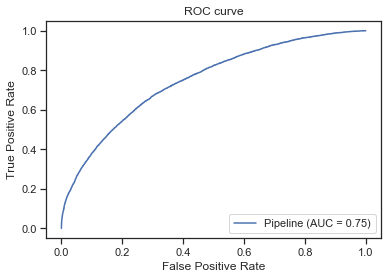

In [125]:
voting_pp =  Pipeline(steps=[('preprocessor', preprocessor),
                                    ('clf',voting_clf)])
voting_pp.fit(X_train_small, y_train_small)
voting_preds, voting_pred_probab = evaluate(model=voting_pp ,x=X_valid , y=y_valid )

In [126]:
from sklearn.ensemble import StackingClassifier
estimators = [('m1', m1),
              ('m2', m2),
              ('m3', m3),
              ('m4', m4),
              ('m5', m5)]

stacking_clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1
 )

Confusion Matrix 
               precision    recall  f1-score   support

           0       0.84      0.98      0.90     24297
           1       0.64      0.18      0.28      5702

    accuracy                           0.82     29999
   macro avg       0.74      0.58      0.59     29999
weighted avg       0.80      0.82      0.78     29999

[[23708   589]
 [ 4670  1032]]
ROC-AUC is:0.753


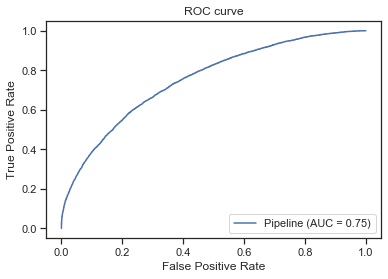

In [127]:
stacking_pp =  Pipeline(steps=[('preprocessor', preprocessor),
                                    ('clf', stacking_clf)])
stacking_pp.fit(X_train_small, y_train_small)
stacking_preds, stacking_pred_probab = evaluate(model=stacking_pp ,x=X_valid , y=y_valid )

In [128]:
# create the final test!
# create the final model with best params found 
final_model = voting_pp
final_model.fit(X_train, y_train)
final_preds_probab = final_model.predict_proba(X_test)[:, 1]

In [129]:
# save results to submit
pd.Series(final_preds_probab,name='delayed').to_csv('submission_cc.csv', index_label='id', header=True)